# Лабораторная работа № 3. Статистический анализ данных о тепловой нагрузке блоков усиления мощности.

В работе проводится анализ данных о температуре и техническом состоянии совокупности блоков усиления мощности. Определяется взаимосвязь их технического состоянии с общим состоянием системы.

Составитель работы - Львов К.В., аспирант физического факультета МГУ им. М.В. Ломоносова. 2021.

## Введение

Современные радиолокационные станции (РЛС) – это структурно-сложные радиотехнические и информационные системы, характеризующиеся высокой надежностью функционирования и большим числом цифровых компонентов в своем составе. Одним из таких компонентов является блок усиления мощности (БУМ), задача которого усиливать передаваемый или принимаемый сигнал.

Функционирование БУМ приводит к их нагреву, что может сказаться на снижении их работоспособности или даже привести к отказу. Под системой в этой работе мы будем понимать несколько БУМ, объединенных в единое целое. Тогда техническое состояние всей системы будет определяться техническим состоянием ее компонент, т.е. состоянием БУМ в данной работе. Техническое же состояние БУМ напрямую зависит от их температуры: при достижении определенного порога блок перестает работать и начинает охлаждаться. После охлаждения до определенной температуры он снова переходит в рабоспособное состояние.

Основная задача - спрогнозировать увеличение температуры блоков усиления мощности на основании истории их функционирования и режима работы блоков, который задает интенсивность нагрева, и возможный выход из строя всей системы блоков. Соответственно, необходимо определить критерий, на основании которого делается вывод о техническом состоянии системы, т.е. установить соответствие между состояниями блоков и состоянием системы. Именно этой задаче и будет посвящена данная лабораторная работа.

## Описание файла с данными

Подключим стандартные пакеты для работы с данными и построения графиков

In [166]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
%matplotlib inline

Загрузим файл с данными и выведем на экран первые 5 строк. Получим информацию по каждой колонке.

In [167]:
df = pd.read_csv("Lab3_data.csv")
df.head()

,mode,temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,system_state
0,3,28.286114,28.043155,27.282141,28.704673,26.530050,30.627461,29.912560,29.724531,29.358333,1.0
1,4,34.142434,35.346311,34.829661,35.079161,35.740529,38.070576,38.675433,36.362013,35.819681,1.0
2,2,34.813586,36.781106,34.445407,34.423135,35.091298,37.398229,38.883147,36.309084,35.741195,1.0
3,4,39.946499,43.133120,40.372435,39.102817,42.374502,41.829684,44.227679,42.699515,41.328171,1.0
4,4,43.950857,47.014358,44.162152,43.810740,45.837267,45.189761,47.661803,46.020946,46.441315,1.0


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205950 entries, 0 to 1205949
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   mode          1205950 non-null  int64  
 1   temp1         1205950 non-null  float64
 2   temp2         1205950 non-null  float64
 3   temp3         1205950 non-null  float64
 4   temp4         1205950 non-null  float64
 5   temp5         1205950 non-null  float64
 6   temp6         1205950 non-null  float64
 7   temp7         1205950 non-null  float64
 8   temp8         1205950 non-null  float64
 9   temp9         1205950 non-null  float64
 10  system_state  1205950 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 101.2 MB


Первая колонка **mode** обозначает номер режима работы блоков. Этот режим определяет интенсивность нагрева блоков. Следующие 9 колонок содержат в себе информацию о температуре каждого из 9-ти БУМ в каждый момент времени. Последняя колонка - бинарный признак работоспособности всей системы блоков.

## Определение температурных порогов отключения и включения блоков

Посмотрим на динамику температуры для каждого блока. Отчетливо видно, что существуют области почти линейного уменьшения температуры - периоды охлаждения блоков. В этом задании требуется определить температурные пороги, достижение которых приводит к отлючению блоков или, наоборот, к возврату их в работоспособное состояние. Также требуется сделать вывод о похожести блоков.

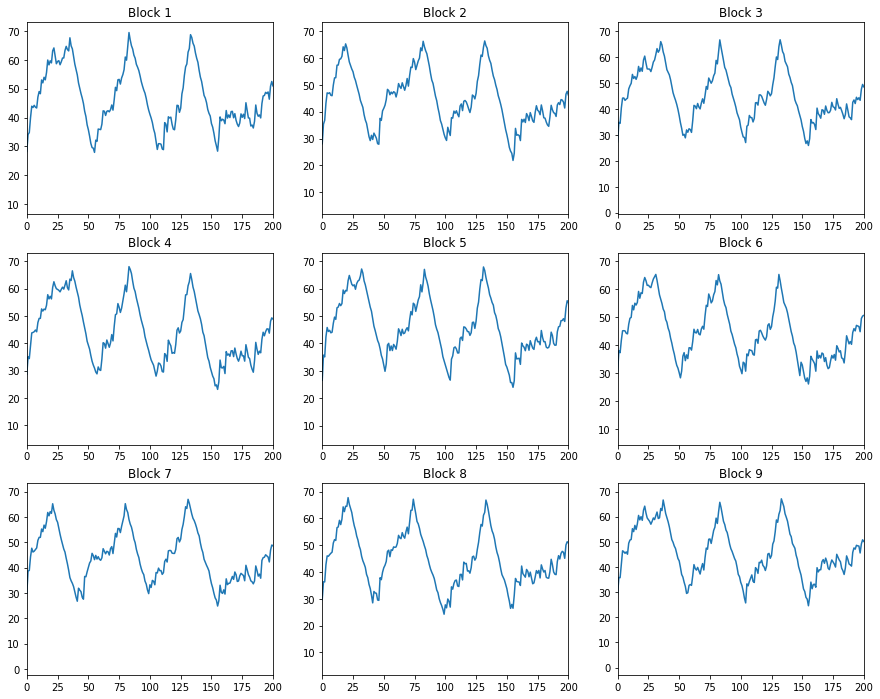

In [169]:
plt.figure(figsize=(15,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(df['temp'+str(i+1)])
    plt.xlim(0,200)
    plt.title('Block '+str(i+1))
plt.show()

Напишите функцию, которая бы по данным о температуре для конкретного блока (тип **Series**) определяла области, в которых происходит охлаждение блока. Параметр **threshold** задает минимальную длительность такой области.

In [170]:
def find_decreasing_regions(series, threshold = 3):

    peaks_up, _ = find_peaks(series, distance=threshold, threshold=[0,6], height=64.7)
    peaks_down, _ = find_peaks(series*-1, distance=threshold, threshold=[0,30], height=-33)

    i = 0
    j = 0
    des = []
    while(i < (len(peaks_up) - 1)):
        des.append([peaks_up[i],peaks_down[np.argmax(peaks_down > peaks_up[i])]])
        i+=1


    # plt.figure(figsize=(25,3))
    # plt.plot(series)
    # peaks_up_new = list(map(lambda x: x[0], des))
    # peaks_dw_new = list(map(lambda x: x[1], des))
    # plt.plot(peaks_up_new, (series)[peaks_up_new], 'gx')
    # plt.plot(peaks_dw_new, (series)[peaks_dw_new], 'rx')
    # plt.xlim(0,1000)
    # print(des[200:210])

    return des

Определим области охлаждения для каждого блока

In [171]:
%%time
block_names = ['temp1','temp2','temp3','temp4','temp5','temp6','temp7','temp8','temp9']
# block_names = ['temp1']
decreasing_regions = [find_decreasing_regions(df[name]) for name in block_names]

CPU times: user 3.99 s, sys: 16 ms, total: 4 s
Wall time: 4 s


Напишите функции, которые бы выдавали список значений температур, при которых произошло отключение блока и его повторное включение после охлаждения, для каждого блока.

In [172]:
def find_max_temp(regions, series):
    
    peaks_max_new = list(map(lambda x: x[0], regions))
    
    return series[peaks_max_new]

def find_min_temp(regions, series):
    
    peaks_min_new = list(map(lambda x: x[1], regions))
    
    return series[peaks_min_new]

Определим значения температур, при которых произошло отключение блоков и их повторное включение после охлаждения.

In [173]:
max_temp = [find_max_temp(decreasing_regions[i], df['temp'+str(i+1)]) for i in range(9)]
min_temp = [find_min_temp(decreasing_regions[i], df['temp'+str(i+1)]) for i in range(9)]
# max_temp = [list(map(lambda x: x[0], decreasing_regions[i])) for i in range(9)]
# min_temp = [list(map(lambda x: x[1], decreasing_regions[i])) for i in range(9)]

Примените функцию ниже к полученным значениям температур. Наглядно сравните распределение верхних и нижних порогов температур для каждого блока. На основании этих распределений сделайте вывод о похожести блоков.

In [174]:
def hist_min_max_temp(min_max_temp, size=(15,12)):
    plt.figure(figsize=size)
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.hist(min_max_temp[i], bins=100)
        plt.title('Block '+str(i+1))
    plt.show()

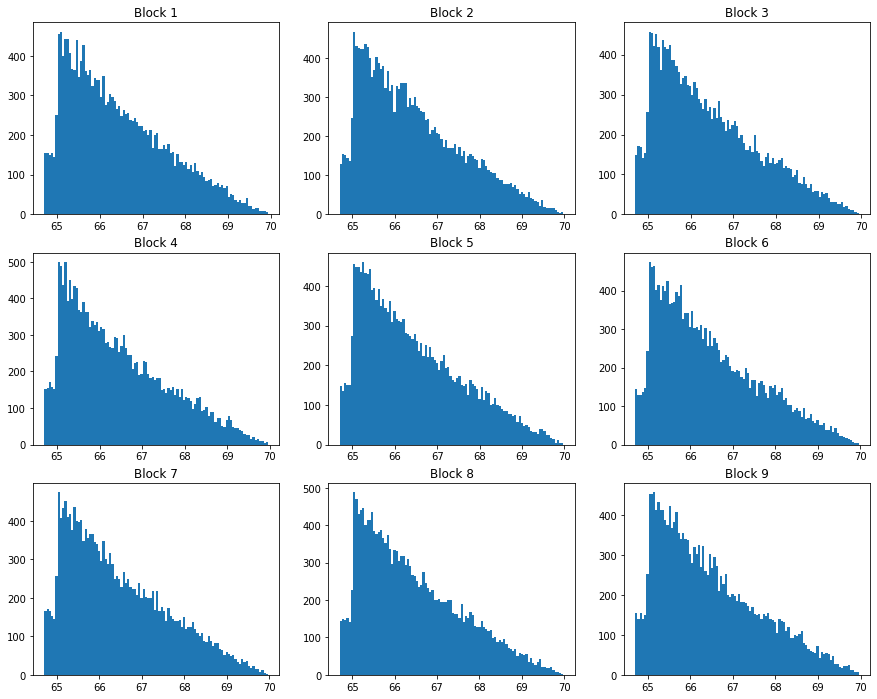

In [175]:
hist_min_max_temp(max_temp)

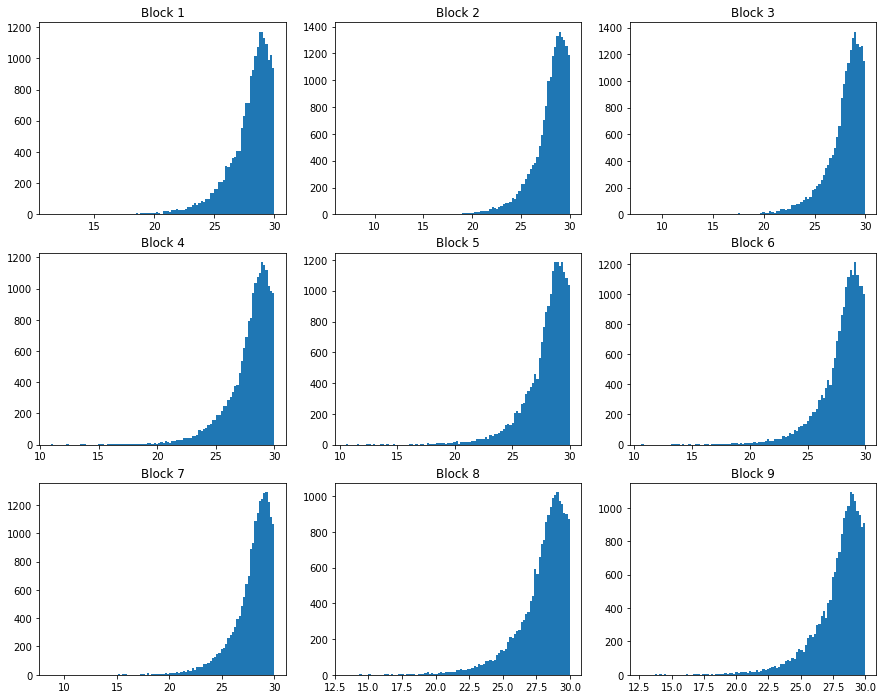

In [176]:
hist_min_max_temp(min_temp)

Вывод: напишите свой вывод здесь.

Определите средние значения температурных порогов для каждого блока и всех блоков в целом.

In [177]:
mean_max_temp = [np.mean(max_temp[i]) for i in range(9)] # напишите свой код здесь
mean_min_temp = [np.mean(min_temp[i]) for i in range(9)] # напишите свой код здесь

print('Mean max_temp: ', mean_max_temp)
print('Mean min_temp: ', mean_min_temp)


Mean max_temp:  [66.42553562763457, 66.43128579348132, 66.42497533961988, 66.42119799996436, 66.42896123083067, 66.4367051154861, 66.43326494094227, 66.42187064568532, 66.4373235418266]
Mean min_temp:  [27.857692872953436, 27.831627088211945, 27.853795477186434, 27.81633173415158, 27.85902099840547, 27.851719361962733, 27.839200024681723, 27.84448955865402, 27.84267234750658]


In [178]:
max_temp_thres = np.mean(mean_max_temp) # напишите свой код здесь
min_temp_thres = np.mean(mean_min_temp) # напишите свой код здесь

print('Max_temp threshold: ', max_temp_thres)
print('Min_temp threshold: ', min_temp_thres)

Max_temp threshold:  66.42901335949679
Min_temp threshold:  27.84406105152377


## Определение технического состояния каждого блока

Напишите функцию, которая бы по известной текущей температуре **temp**, верхнего **max_temp** и нижнего **min_temp** температурных порогов определяла состояние блока в диапазоне от 0 до 1 (0 - блок имеет нижнюю температуру, 1 - верхнюю). При этом значения температуры, выше верхнего порога должны соответствовать состоянию 0, а температуры, ниже нижнего порога - состоянию 1. 

In [179]:
def get_state(temp, max_temp, min_temp):

    

    return 

Добавьте в DataFrame новые столбцы 'state1' и т.д., содержащие состояния блоков. Учтите, что в те промежутки, когда блок остывает и находится в выключенном состоянии, его состояние должно быть равно 0.

In [180]:
df_copy = df.copy()
print(df_copy.temp1[decreasing_regions[i][0][0]:decreasing_regions[i][0][1]])

37    63.817740
38    61.043440
39    58.515454
40    56.608533
41    54.806397
42    51.997429
43    50.084903
44    48.326181
45    46.780680
46    44.888066
47    42.180060
48    40.385189
49    37.488920
50    35.802952
51    33.578652
52    31.071147
53    29.630258
54    29.410084
55    27.946372
Name: temp1, dtype: float64


/home/amon/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/amon/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/amon/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

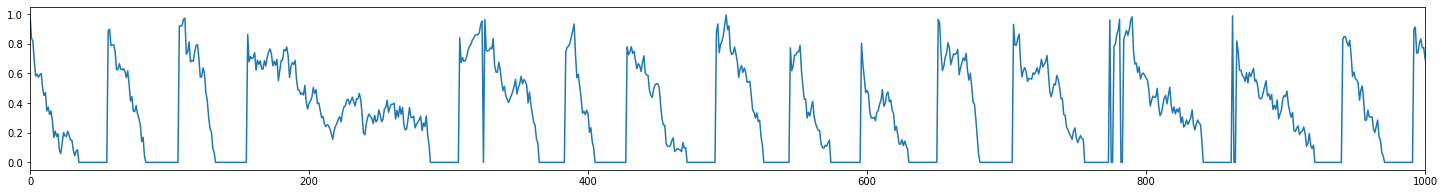

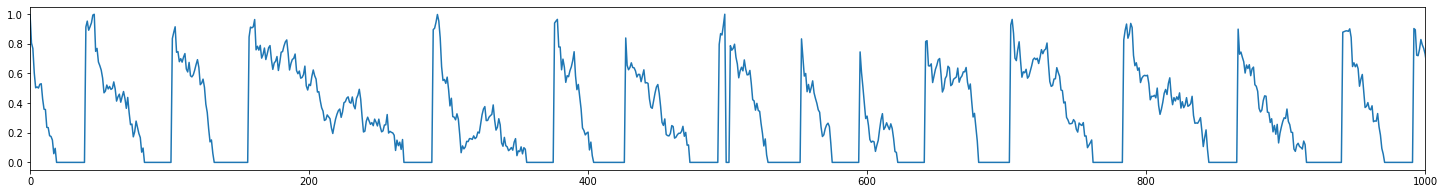

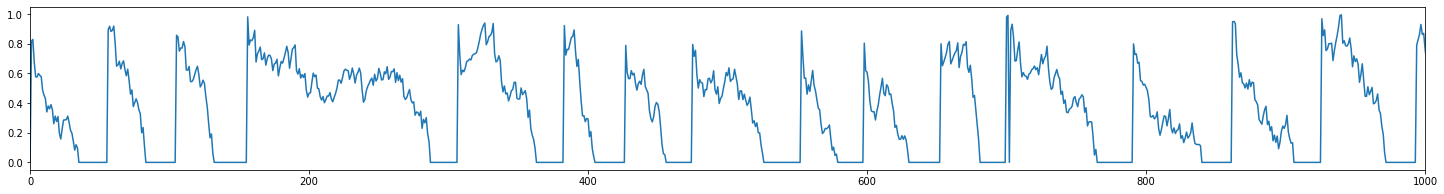

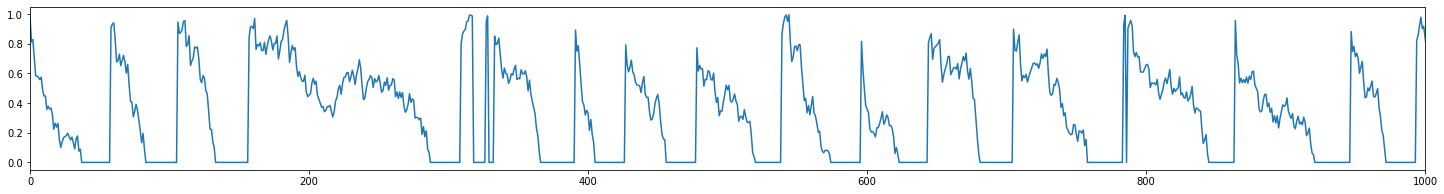

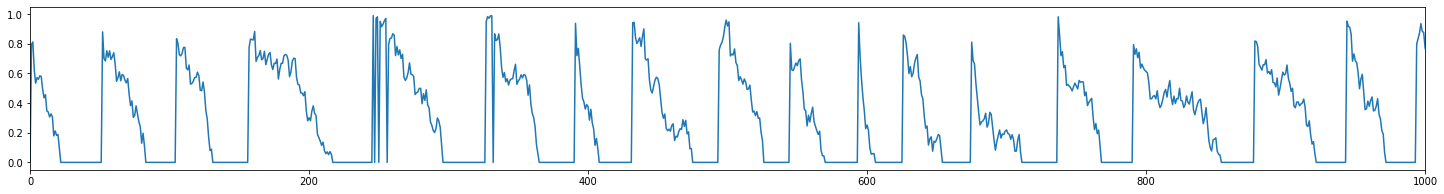

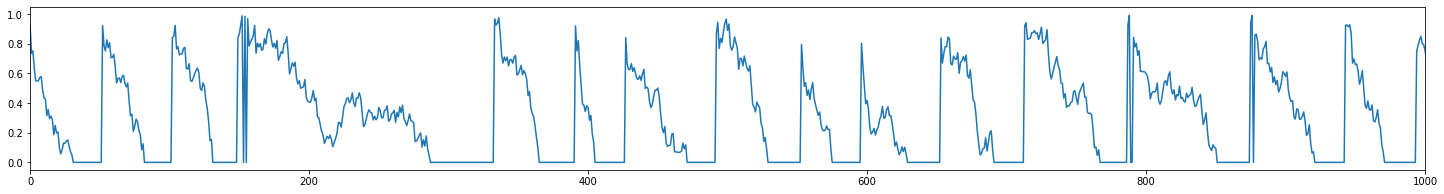

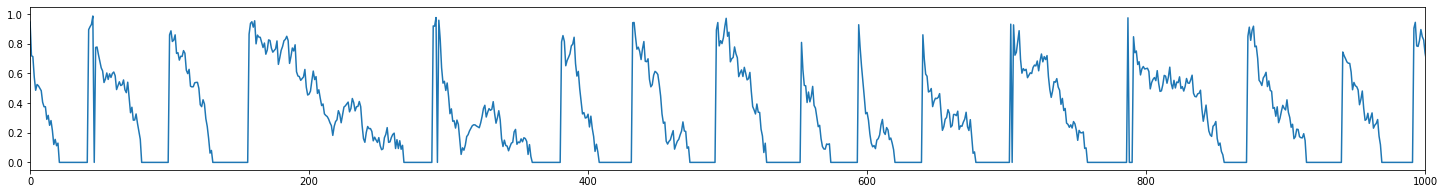

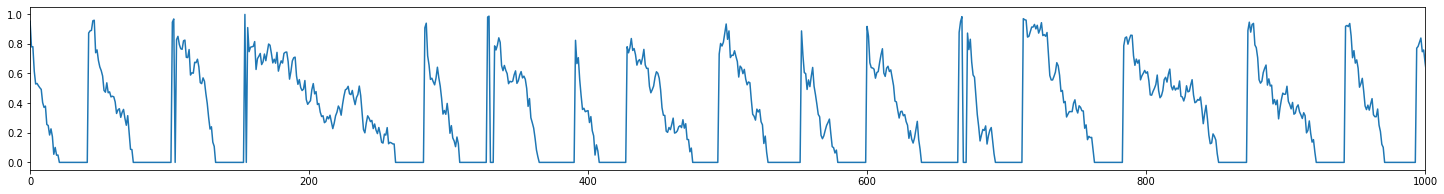

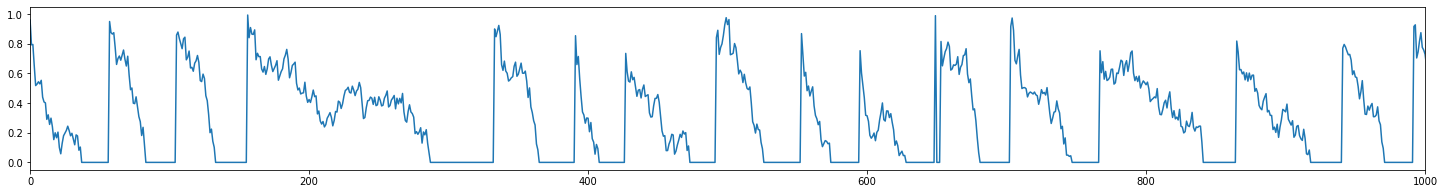

In [181]:
for i in range(9):
    ser = df_copy[block_names[i]]
    mins = mean_min_temp[i]
    maxs = mean_max_temp[i]
    ranges = mean_max_temp[i] - mean_min_temp[i]

    # ser.is_copy = False
    for j in range(len(decreasing_regions[i])):
        ser.loc[decreasing_regions[i][j][0]:decreasing_regions[i][j][1]] = 0

    a = np.where(ser<mins,0,(np.where(ser>maxs,1,1 - ((ser-mins)/ranges))))
    
    df["state"+str(i+1)] = a.tolist()
    plt.figure(figsize=(25,3))
    plt.plot(a)
    plt.xlim(0,1000)


In [182]:
df.head()

,mode,temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,system_state,state1,state2,state3,state4,state5,state6,state7,state8,state9
0,3,28.286114,28.043155,27.282141,28.704673,26.530050,30.627461,29.912560,29.724531,29.358333,1.0,0.988892,0.994520,0.000000,0.976989,0.000000,0.928062,0.946278,0.951266,0.960729
1,4,34.142434,35.346311,34.829661,35.079161,35.740529,38.070576,38.675433,36.362013,35.819681,1.0,0.837047,0.805317,0.819143,0.811868,0.795657,0.735160,0.719225,0.779209,0.793313
2,2,34.813586,36.781106,34.445407,34.423135,35.091298,37.398229,38.883147,36.309084,35.741195,1.0,0.819645,0.768146,0.829105,0.828861,0.812489,0.752585,0.713843,0.780581,0.795347
3,4,39.946499,43.133120,40.372435,39.102817,42.374502,41.829684,44.227679,42.699515,41.328171,1.0,0.686557,0.603585,0.675441,0.707641,0.623658,0.637736,0.575363,0.614929,0.650586
4,4,43.950857,47.014358,44.162152,43.810740,45.837267,45.189761,47.661803,46.020946,46.441315,1.0,0.582731,0.503034,0.577188,0.585689,0.533879,0.550653,0.486382,0.528831,0.518103


Построим сравнительный график столбцов 'temp9' и 'state9' - проверим правильность перевода температуры в состояние.

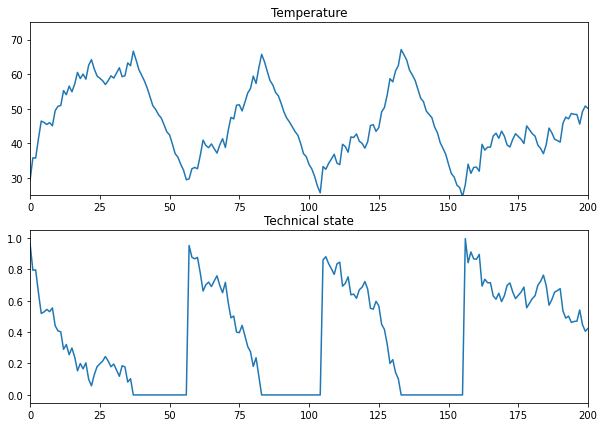

In [183]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(df['temp9'])
plt.xlim(0,200)
plt.ylim(25,75)
plt.title('Temperature')
plt.subplot(2,1,2)
plt.plot(df['state9'])
plt.xlim(0,200)
plt.title('Technical state')
plt.show()

## Корреляции технического состояния блоков с состоянием системы

Построим друг над другом графики состояния системы и состояния блоков, чтобы определить возможную взаимосвязь этих величин.

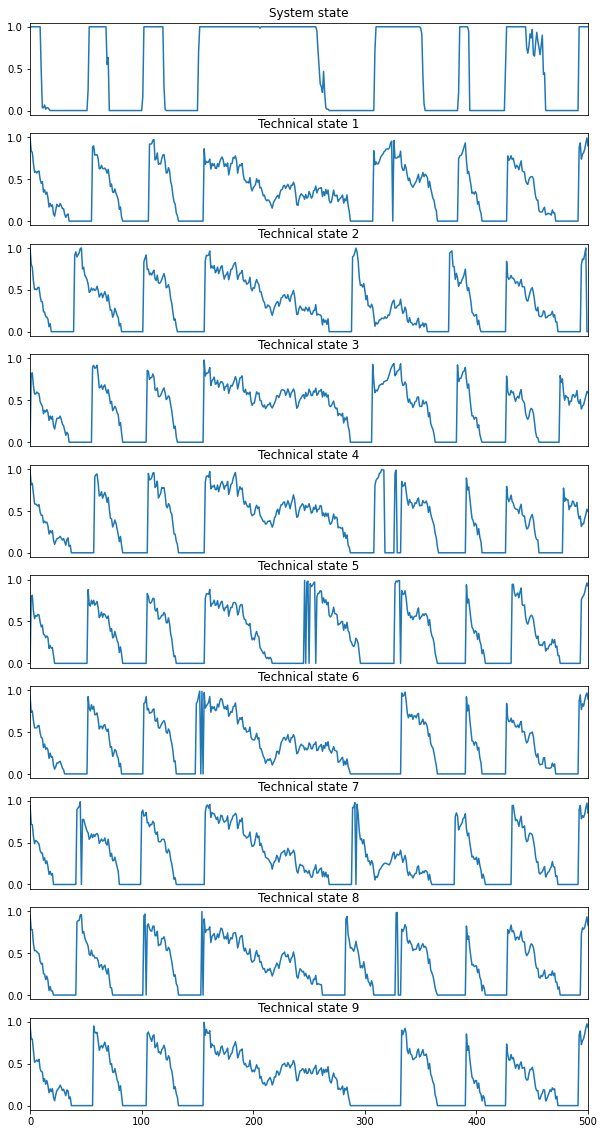

In [184]:
plt.figure(figsize=(10,20))
plt.subplot(10,1,1)
plt.plot(df['system_state'])
plt.xlim(0,500)
plt.xticks([])
plt.title('System state')
for i in range(9):
    plt.subplot(10,1,i+2)
    plt.plot(df['state'+str(i+1)])
    plt.xlim(0,500)
    if i < 8:
        plt.xticks([])
    plt.title('Technical state '+str(i+1))
plt.show()

Наглядно видно, что состояние системы становится равным 0, когда какая-то часть блоков отключается и начинает охлаждаться. Поскольку блоки идентичные, то можно предположить, что каждый из них одинаковым образом влияет на состояния системы. Поэтому определим взаимосвязь состояния системы со средним значением состояния блоков.

Определите среднее состояние блоков с помощью метода **pd.DataFrame.agg()**.

In [185]:
# sum_state = df.loc[:,['state'+str(i+1) for i in range(9)]].agg([np.mean],axis=1)
sum_state = df.loc[:,'state1':'state9'].agg(sum, axis = 1) / 9

Сравним на графиках состояние системы и среднее состояние блоков.

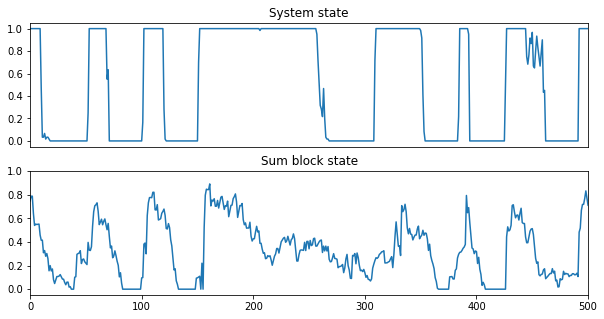

In [186]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(df['system_state'])
plt.xlim(0,500)
plt.xticks([])
plt.title('System state')
plt.subplot(2,1,2)
plt.plot(sum_state)
plt.xlim(0,500)
plt.title('Sum block state')
plt.show()

Для того, чтобы по состоянию блоков можно было определять состояние системы, нужно выбрать пороговое значение состояния блоков, выше которого состояние системы будет прогнозироваться равным 1, а ниже - равным 0. Сделаем это обычным перебором. Но для начала приведем значения состояния системы либо к значению 0, либо к значению 1.

Напишите функцию, которая будет рассчитывать точность соответствия состояния системы **system_state** и среднего состояния блоков **sum_state** для определенного порогового значения **threshold**. Точность - относительное число точных совпадений состояний блоков и системы (1 и 1 или 0 и 0).

In [187]:
system_state = np.ones(len(df))
system_state[df['system_state'] < 0.5] = 0

In [188]:
def accuracy(system_state, sum_state, threshold):
    new = np.where(sum_state<threshold,0.,1.)
    new.shape = (len(new),)
    some = np.zeros(len(df))
    some[new == system_state] = 1
    return np.sum(some)/len(some)

Определим точность для каждого значения порога в интервале от 0 до 1.

In [189]:
acc = []
thresholds = np.linspace(0., 1., num = 100)

for thres in thresholds:
    acc.append(accuracy(system_state,sum_state,thres))


Построим график зависимости точности от порога. На графике виден максимум, соответствующий оптимальному значению порога.

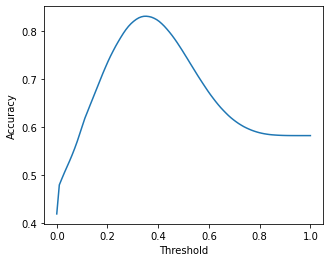

In [190]:
plt.figure(figsize=(5,4))
plt.plot(thresholds, acc)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

Определите максимальное значение точности и оптимальное значение порога.

In [191]:
max_accuracy = np.max(acc) # напишите свой код здесь
optimal_threshold = thresholds[np.argmax(acc)] # напишите свой код здесь

print('Maximum accuracy {:.3f} for the threshold {:.3f}'.format(max_accuracy, optimal_threshold))

Maximum accuracy 0.830 for the threshold 0.354


## Выводы

Напишите ниже выводы по результатам лабораторной работы.